<a href="https://colab.research.google.com/github/nasare34/ResNet50-Vision-Transformer-for-GI-Pathology-Detection/blob/main/ViT_Kvasir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Step 1: Mount Google Drive & Load Dataset



In [ ]:


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.metrics import confusion_matrix, classification_report




In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision.datasets import ImageFolder
from torchvision.models import resnet50

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Define the dataset path
dataset_path = '/content/drive/My Drive/kvasir-dataset'

In [ ]:
# Verify the contents of the dataset directory
import os
print("Files in dataset directory:")
print(os.listdir(dataset_path))

Files in dataset directory:
['ulcerative-colitis', 'dyed-lifted-polyps', 'esophagitis', 'normal-pylorus', 'polyps', 'normal-cecum', 'dyed-resection-margins', 'normal-z-line']


In [ ]:
import os

# Get class directories inside the dataset path
dataset_classes = sorted([d for d in os.listdir(dataset_path) if not d.startswith('.')])
print("Classes in dataset:", dataset_classes)


Classes in dataset: ['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis', 'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis']


In [ ]:
import os

# Define path
ds_store_path = os.path.join(dataset_path, ".DS_Store")

# Check if .DS_Store exists and remove it
if os.path.exists(ds_store_path):
    os.remove(ds_store_path)
    print(".DS_Store removed successfully!")
else:
    print("No .DS_Store file found.")


No .DS_Store file found.


#Step 2: Define Image Transformations & Load Dataset



In [ ]:
# Image Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
full_dataset = ImageFolder(root=dataset_path, transform=transform)
num_classes = len(full_dataset.classes)

# Train-Test-Validation Split (80:10:10)
dataset_size = len(full_dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Train: {len(train_dataset)} images, Validation: {len(val_dataset)} images, Test: {len(test_dataset)} images")


Train: 3319 images, Validation: 414 images, Test: 416 images


<ipython-input-9-b79b5af26f77>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=class_names, y=counts, palette="viridis")


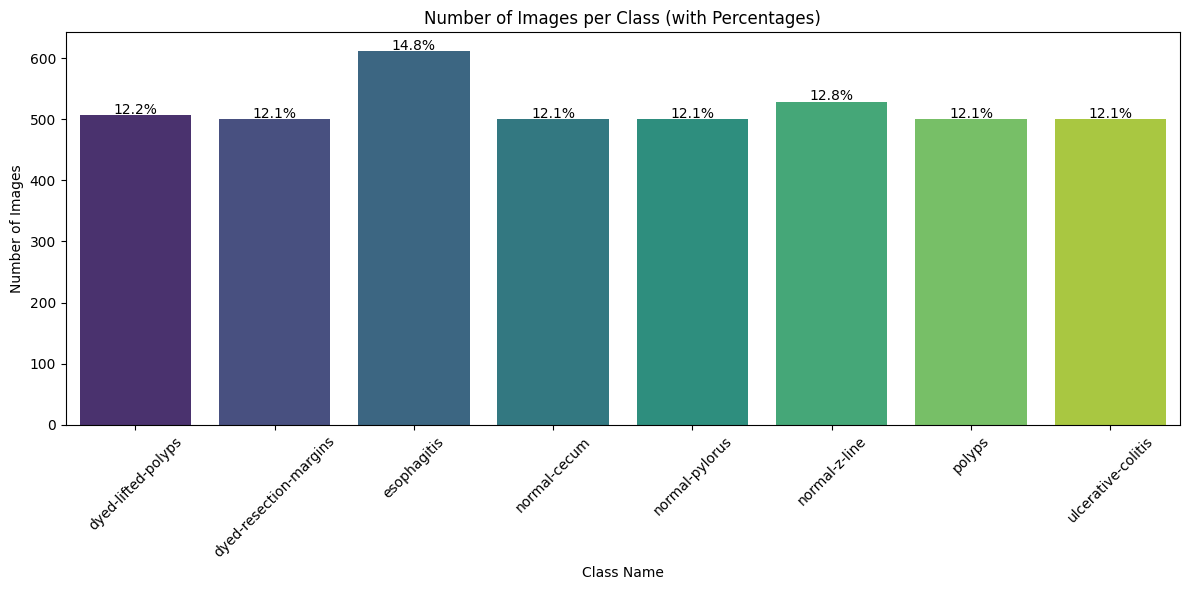

In [ ]:
from collections import Counter

# Count images per class
class_counts = Counter(full_dataset.targets)
class_names = full_dataset.classes

# Sort by class index to align names with counts
counts = [class_counts[i] for i in range(len(class_names))]
total_images = sum(counts)
percentages = [count / total_images * 100 for count in counts]

# Plot histogram with counts and percentages
plt.figure(figsize=(12, 6))
bars = sns.barplot(x=class_names, y=counts, palette="viridis")

# Annotate bars with percentage
for i, bar in enumerate(bars.patches):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 2,
             f"{percentages[i]:.1f}%", ha='center', fontsize=10, color='black')

plt.title("Number of Images per Class (with Percentages)")
plt.xlabel("Class Name")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<ipython-input-10-693ac5574481>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=class_names, y=counts, palette="viridis")


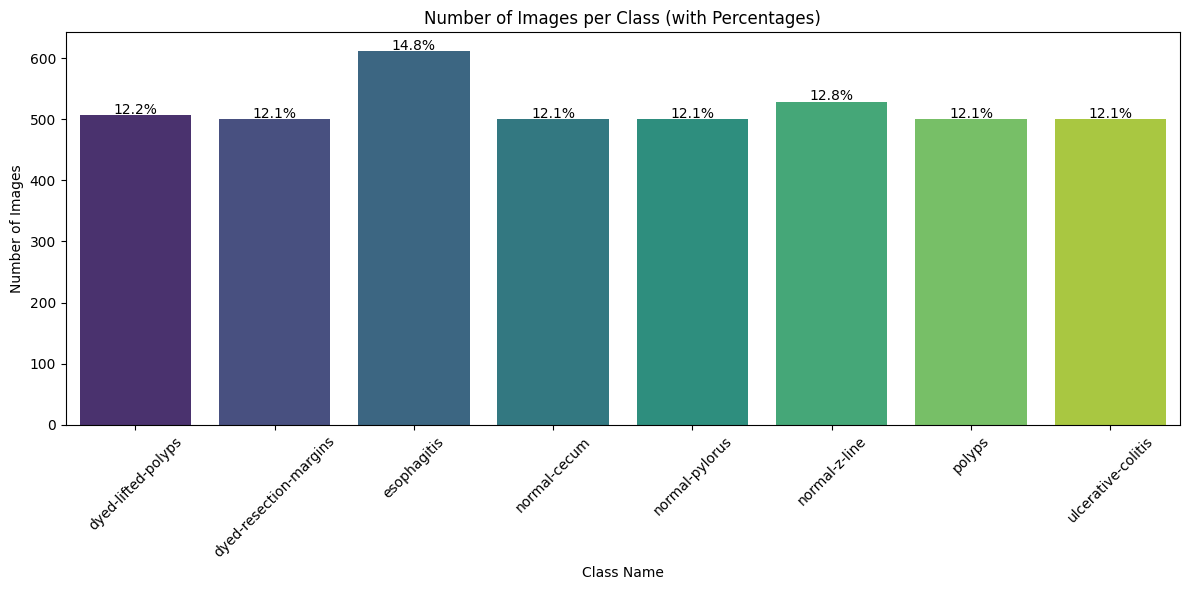

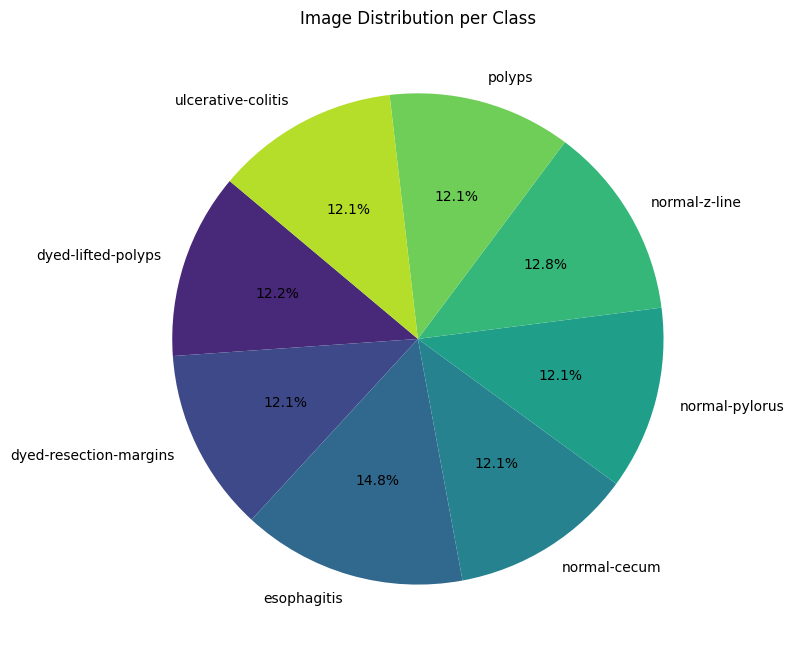


Class Distribution Table:
                 Class  Count Percentage
    dyed-lifted-polyps    507     12.22%
dyed-resection-margins    500     12.05%
           esophagitis    612     14.75%
          normal-cecum    500     12.05%
        normal-pylorus    501     12.08%
         normal-z-line    529     12.75%
                polyps    500     12.05%
    ulcerative-colitis    500     12.05%


In [ ]:
from collections import Counter
import pandas as pd

# Count images per class
class_counts = Counter(full_dataset.targets)
class_names = full_dataset.classes

# Prepare data
counts = [class_counts[i] for i in range(len(class_names))]
total_images = sum(counts)
percentages = [count / total_images * 100 for count in counts]

# ----- Histogram -----
plt.figure(figsize=(12, 6))
bars = sns.barplot(x=class_names, y=counts, palette="viridis")

# Annotate with percentages
for i, bar in enumerate(bars.patches):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 2,
             f"{percentages[i]:.1f}%", ha='center', fontsize=10, color='black')

plt.title("Number of Images per Class (with Percentages)")
plt.xlabel("Class Name")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ----- Pie Chart -----
plt.figure(figsize=(8, 8))
colors = sns.color_palette("viridis", len(class_names))
plt.pie(counts, labels=class_names, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title("Image Distribution per Class")
plt.tight_layout()
plt.show()

# ----- Table Output -----
df = pd.DataFrame({
    'Class': class_names,
    'Count': counts,
    'Percentage': [f"{p:.2f}%" for p in percentages]
})
print("\nClass Distribution Table:")
print(df.to_string(index=False))


#Step 3: Load Pretrained ViT & Modify for Kvasir Dataset

---





In [ ]:
import torch
from torchvision import models
import torch.nn as nn
import torch.optim as optim

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pretrained Vision Transformer
vit = models.vit_b_16(pretrained=True)


in_features = vit.heads[-1].in_features
vit.heads = nn.Linear(in_features, num_classes)

# Move model to GPU if available
vit = vit.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit.parameters(), lr=0.0001)

Using device: cuda


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:04<00:00, 72.7MB/s]


#Step 4: Train the Model

In [ ]:
# Training function
def train_model(model, train_loader, val_loader, epochs=10):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        train_correct, train_total = 0, 0
        running_loss = 0.0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backpropagation
            loss.backward()
            optimizer.step()

            # Accuracy
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * train_correct / train_total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        val_correct, val_total = 0, 0
        val_loss = 0.0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_accuracy = 100 * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the ViT model
epochs = 30
train_losses, val_losses, train_accuracies, val_accuracies = train_model(vit, train_loader, val_loader, epochs)


Epoch 1/30: 100%|██████████| 104/104 [21:29<00:00, 12.40s/it]


Epoch 1: Train Loss: 0.4596, Train Acc: 82.80% | Val Loss: 0.2944, Val Acc: 87.68%


Epoch 2/30: 100%|██████████| 104/104 [01:47<00:00,  1.03s/it]


Epoch 2: Train Loss: 0.2460, Train Acc: 90.54% | Val Loss: 0.2436, Val Acc: 90.58%


Epoch 3/30: 100%|██████████| 104/104 [01:49<00:00,  1.05s/it]


Epoch 3: Train Loss: 0.1677, Train Acc: 93.49% | Val Loss: 0.2671, Val Acc: 89.86%


Epoch 4/30: 100%|██████████| 104/104 [01:50<00:00,  1.06s/it]


Epoch 4: Train Loss: 0.1196, Train Acc: 95.54% | Val Loss: 0.2206, Val Acc: 94.20%


Epoch 5/30: 100%|██████████| 104/104 [01:53<00:00,  1.09s/it]


Epoch 5: Train Loss: 0.1126, Train Acc: 95.93% | Val Loss: 0.2624, Val Acc: 91.55%


Epoch 6/30: 100%|██████████| 104/104 [01:52<00:00,  1.08s/it]


Epoch 6: Train Loss: 0.1083, Train Acc: 95.99% | Val Loss: 0.2212, Val Acc: 93.00%


Epoch 7/30: 100%|██████████| 104/104 [01:52<00:00,  1.08s/it]


Epoch 7: Train Loss: 0.0876, Train Acc: 96.84% | Val Loss: 0.3145, Val Acc: 89.37%


Epoch 8/30: 100%|██████████| 104/104 [01:52<00:00,  1.08s/it]


Epoch 8: Train Loss: 0.0970, Train Acc: 96.32% | Val Loss: 0.3205, Val Acc: 90.82%


Epoch 9/30: 100%|██████████| 104/104 [01:52<00:00,  1.08s/it]


Epoch 9: Train Loss: 0.0775, Train Acc: 97.05% | Val Loss: 0.3531, Val Acc: 90.10%


Epoch 10/30: 100%|██████████| 104/104 [01:52<00:00,  1.08s/it]


Epoch 10: Train Loss: 0.0625, Train Acc: 97.68% | Val Loss: 0.3386, Val Acc: 89.86%


Epoch 11/30: 100%|██████████| 104/104 [01:52<00:00,  1.09s/it]


Epoch 11: Train Loss: 0.0696, Train Acc: 97.41% | Val Loss: 0.2960, Val Acc: 92.03%


Epoch 12/30: 100%|██████████| 104/104 [01:52<00:00,  1.08s/it]


Epoch 12: Train Loss: 0.0636, Train Acc: 97.59% | Val Loss: 0.3417, Val Acc: 91.30%


Epoch 13/30: 100%|██████████| 104/104 [01:52<00:00,  1.08s/it]


Epoch 13: Train Loss: 0.0578, Train Acc: 98.01% | Val Loss: 0.3274, Val Acc: 90.82%


Epoch 14/30: 100%|██████████| 104/104 [01:52<00:00,  1.08s/it]


Epoch 14: Train Loss: 0.0431, Train Acc: 98.49% | Val Loss: 0.3094, Val Acc: 92.03%


Epoch 15/30: 100%|██████████| 104/104 [01:51<00:00,  1.08s/it]


Epoch 15: Train Loss: 0.0546, Train Acc: 98.13% | Val Loss: 0.3954, Val Acc: 89.86%


Epoch 16/30: 100%|██████████| 104/104 [01:52<00:00,  1.08s/it]


Epoch 16: Train Loss: 0.0485, Train Acc: 98.31% | Val Loss: 0.3504, Val Acc: 90.58%


Epoch 17/30: 100%|██████████| 104/104 [01:52<00:00,  1.08s/it]


Epoch 17: Train Loss: 0.0447, Train Acc: 98.46% | Val Loss: 0.3180, Val Acc: 92.03%


Epoch 18/30: 100%|██████████| 104/104 [01:51<00:00,  1.07s/it]


Epoch 18: Train Loss: 0.0647, Train Acc: 97.89% | Val Loss: 0.2715, Val Acc: 91.79%


Epoch 19/30: 100%|██████████| 104/104 [01:51<00:00,  1.07s/it]


Epoch 19: Train Loss: 0.0453, Train Acc: 98.43% | Val Loss: 0.4390, Val Acc: 88.41%


Epoch 20/30: 100%|██████████| 104/104 [01:52<00:00,  1.08s/it]


Epoch 20: Train Loss: 0.0432, Train Acc: 98.58% | Val Loss: 0.3815, Val Acc: 90.58%


Epoch 21/30: 100%|██████████| 104/104 [01:52<00:00,  1.08s/it]


Epoch 21: Train Loss: 0.0200, Train Acc: 99.37% | Val Loss: 0.3063, Val Acc: 93.00%


Epoch 22/30: 100%|██████████| 104/104 [01:51<00:00,  1.07s/it]


Epoch 22: Train Loss: 0.0191, Train Acc: 99.34% | Val Loss: 0.3473, Val Acc: 91.30%


Epoch 23/30: 100%|██████████| 104/104 [01:51<00:00,  1.08s/it]


Epoch 23: Train Loss: 0.0417, Train Acc: 98.67% | Val Loss: 0.3195, Val Acc: 92.75%


Epoch 24/30: 100%|██████████| 104/104 [01:52<00:00,  1.08s/it]


Epoch 24: Train Loss: 0.0654, Train Acc: 97.59% | Val Loss: 0.2931, Val Acc: 92.03%


Epoch 25/30: 100%|██████████| 104/104 [01:52<00:00,  1.08s/it]


Epoch 25: Train Loss: 0.0340, Train Acc: 98.67% | Val Loss: 0.3029, Val Acc: 93.00%


Epoch 26/30: 100%|██████████| 104/104 [01:52<00:00,  1.08s/it]


Epoch 26: Train Loss: 0.0265, Train Acc: 99.04% | Val Loss: 0.3716, Val Acc: 92.27%


Epoch 27/30: 100%|██████████| 104/104 [01:52<00:00,  1.08s/it]


Epoch 27: Train Loss: 0.0458, Train Acc: 98.61% | Val Loss: 0.2309, Val Acc: 92.51%


Epoch 28/30: 100%|██████████| 104/104 [01:52<00:00,  1.08s/it]


Epoch 28: Train Loss: 0.0406, Train Acc: 98.95% | Val Loss: 0.3223, Val Acc: 93.72%


Epoch 29/30: 100%|██████████| 104/104 [01:51<00:00,  1.08s/it]


Epoch 29: Train Loss: 0.0338, Train Acc: 98.92% | Val Loss: 0.2888, Val Acc: 93.00%


Epoch 30/30: 100%|██████████| 104/104 [01:52<00:00,  1.08s/it]


Epoch 30: Train Loss: 0.0228, Train Acc: 99.31% | Val Loss: 0.3016, Val Acc: 91.55%


#Step 5: Plot Training & Validation Loss



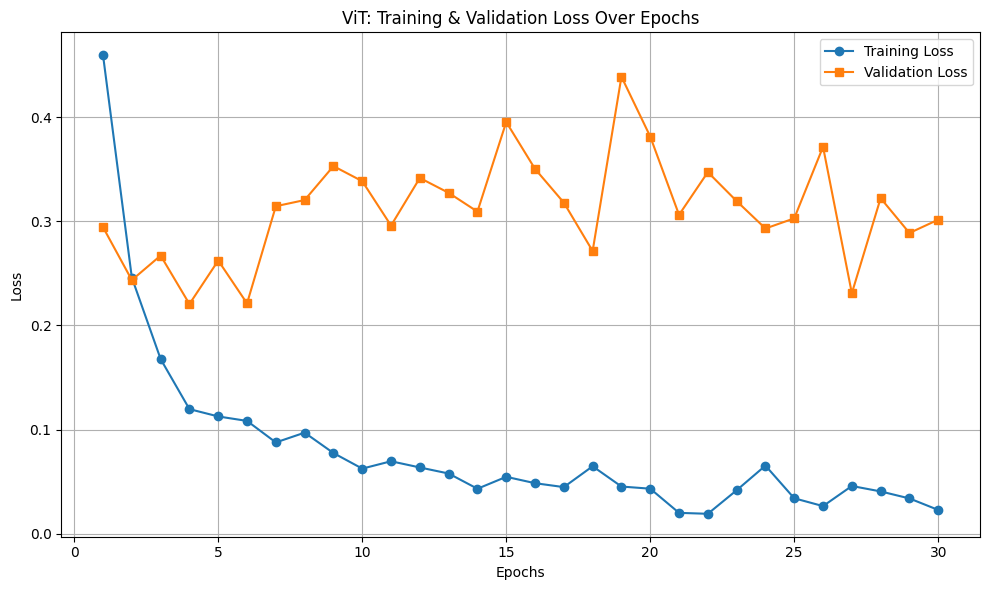

In [ ]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss for ViT
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss", marker='o')
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("ViT: Training & Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


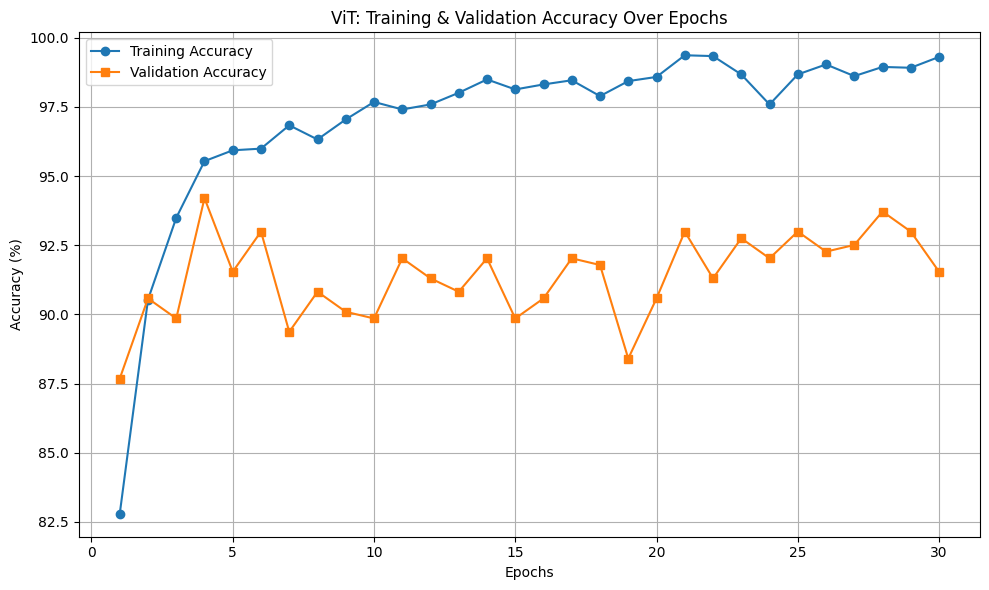

In [ ]:
# Plot Training and Validation Accuracy for ViT
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_accuracies, label="Training Accuracy", marker='o')
plt.plot(range(1, epochs + 1), val_accuracies, label="Validation Accuracy", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("ViT: Training & Validation Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#6 OVERALL TEST ACCURACY

In [ ]:
def overall_accuracy(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    print(f"Overall Test Accuracy: {accuracy:.2f}%")

# Call this function with your ViT model
overall_accuracy(vit, test_loader)


Overall Test Accuracy: 89.18%


# 7. TEST ACCURACY CLASS-WISE

In [ ]:
import numpy as np

def class_wise_accuracy(model, test_loader, class_names):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    print("Class-wise Accuracy:")
    for i, class_name in enumerate(class_names):
        idxs = (y_true == i)
        correct = np.sum(y_pred[idxs] == i)
        total = np.sum(idxs)
        accuracy = 100 * correct / total if total > 0 else 0
        print(f"  {class_name}: {accuracy:.2f}% ({correct}/{total})")

# Call this function with your ViT model
class_wise_accuracy(vit, test_loader, full_dataset.classes)


Class-wise Accuracy:
  dyed-lifted-polyps: 84.00% (42/50)
  dyed-resection-margins: 94.87% (37/39)
  esophagitis: 91.18% (62/68)
  normal-cecum: 100.00% (51/51)
  normal-pylorus: 97.44% (38/39)
  normal-z-line: 82.26% (51/62)
  polyps: 81.36% (48/59)
  ulcerative-colitis: 93.75% (45/48)


#8. Classification Report and Confusion Matrix




Classification Report:

                        precision    recall  f1-score   support

    dyed-lifted-polyps       0.89      0.78      0.83        50
dyed-resection-margins       0.76      0.87      0.81        39
           esophagitis       0.84      0.91      0.87        68
          normal-cecum       0.88      1.00      0.94        51
        normal-pylorus       0.97      0.97      0.97        39
         normal-z-line       0.96      0.81      0.88        62
                polyps       0.98      0.81      0.89        59
    ulcerative-colitis       0.82      0.94      0.87        48

              accuracy                           0.88       416
             macro avg       0.89      0.89      0.88       416
          weighted avg       0.89      0.88      0.88       416



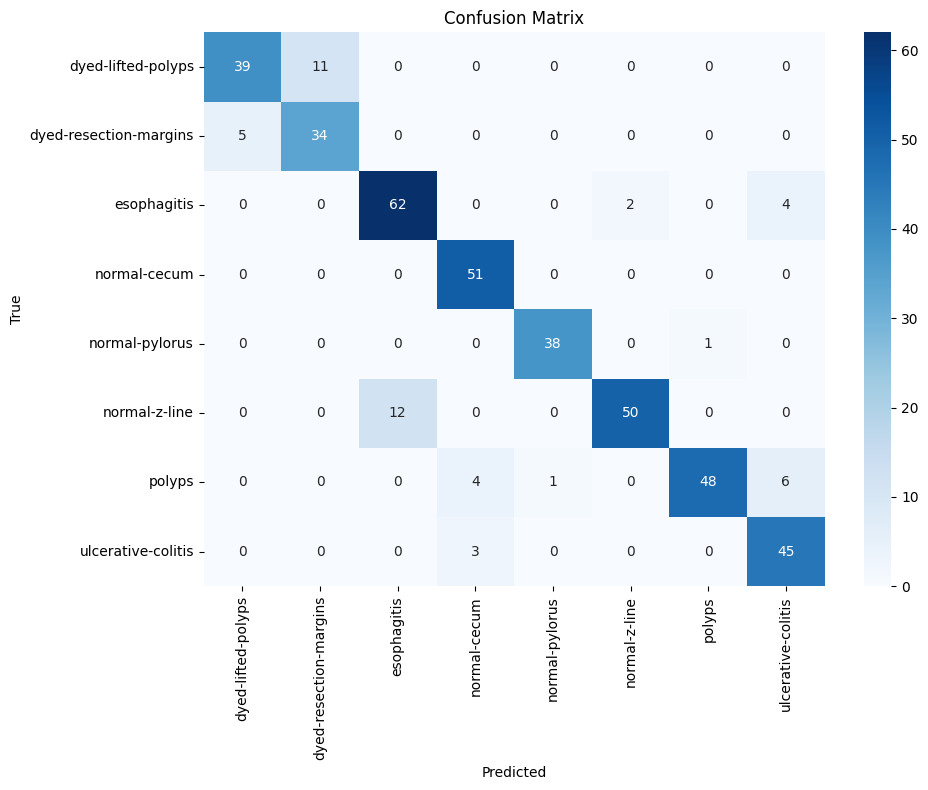

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def classification_report_and_confusion_matrix(model, test_loader, class_names):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

# Call this function with your ViT model
classification_report_and_confusion_matrix(vit, test_loader, full_dataset.classes)


# 9 Multi-Class ROC Curve with AUC



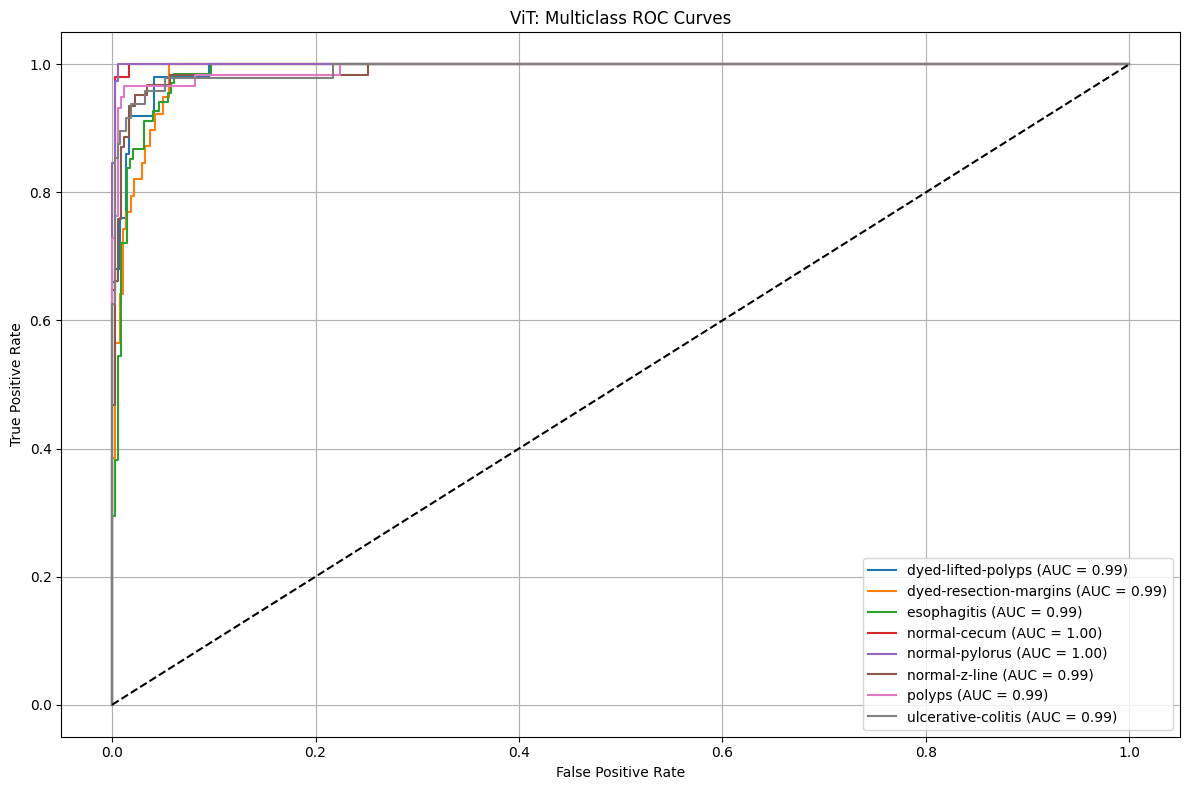

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_roc_curves(model, test_loader, class_names, device):
    model.eval()
    y_true = []
    y_score = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            y_score.extend(outputs.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))
    y_score = np.array(y_score)

    plt.figure(figsize=(12, 8))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ViT: Multiclass ROC Curves')
    plt.legend(loc='lower right')
    plt.grid()
    plt.tight_layout()
    plt.show()

# Call this function with ViT
plot_roc_curves(vit, test_loader, full_dataset.classes, device)


#ROC Curves for Multiclass

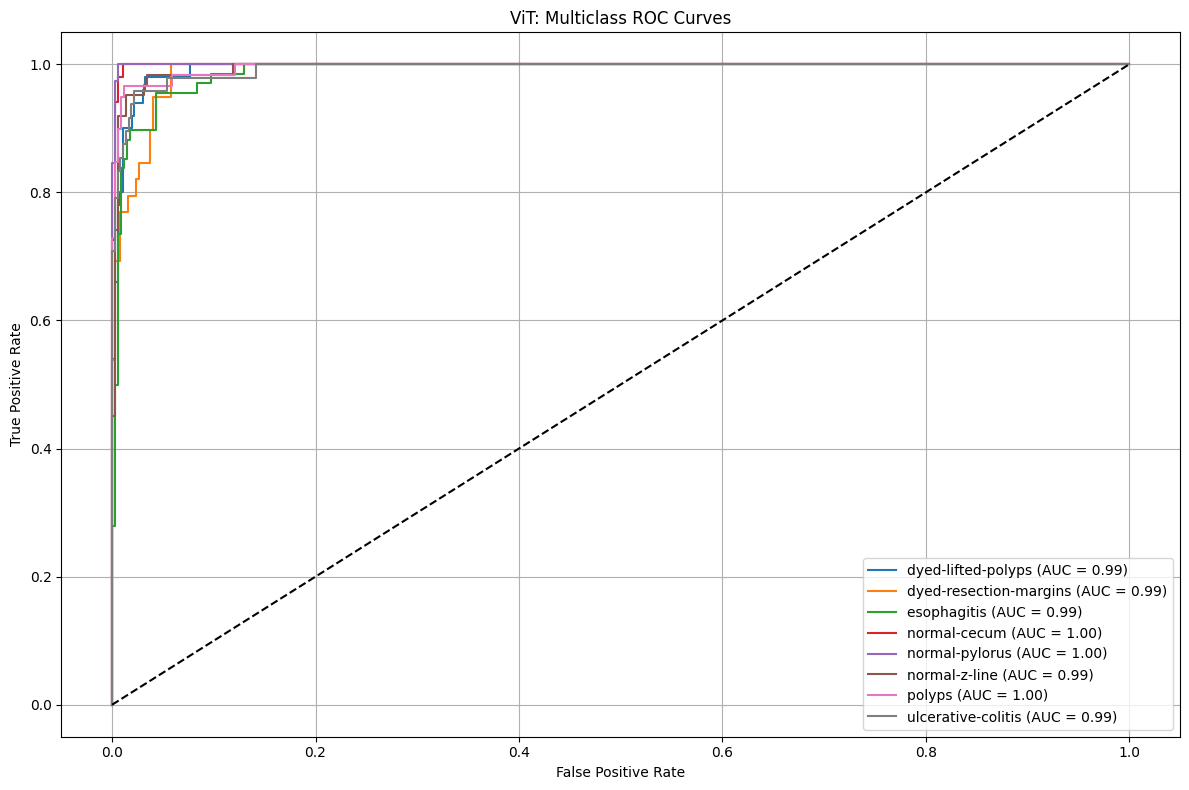

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_roc_curves(model, test_loader, class_names, device):
    model.eval()
    y_true = []
    y_score = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            y_score.extend(outputs.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))
    y_score = np.array(y_score)

    plt.figure(figsize=(12, 8))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ViT: Multiclass ROC Curves')
    plt.legend(loc='lower right')
    plt.grid()
    plt.tight_layout()
    plt.show()

# Call this function with ViT
plot_roc_curves(vit, test_loader, full_dataset.classes, device)



Classification Report:

                        precision    recall  f1-score   support

    dyed-lifted-polyps       0.98      0.93      0.96       507
dyed-resection-margins       0.94      0.98      0.96       500
           esophagitis       0.94      0.98      0.96       612
          normal-cecum       0.98      1.00      0.99       500
        normal-pylorus       1.00      0.99      1.00       501
         normal-z-line       0.99      0.93      0.96       529
                polyps       0.99      0.96      0.97       500
    ulcerative-colitis       0.96      0.99      0.98       500

              accuracy                           0.97      4149
             macro avg       0.97      0.97      0.97      4149
          weighted avg       0.97      0.97      0.97      4149



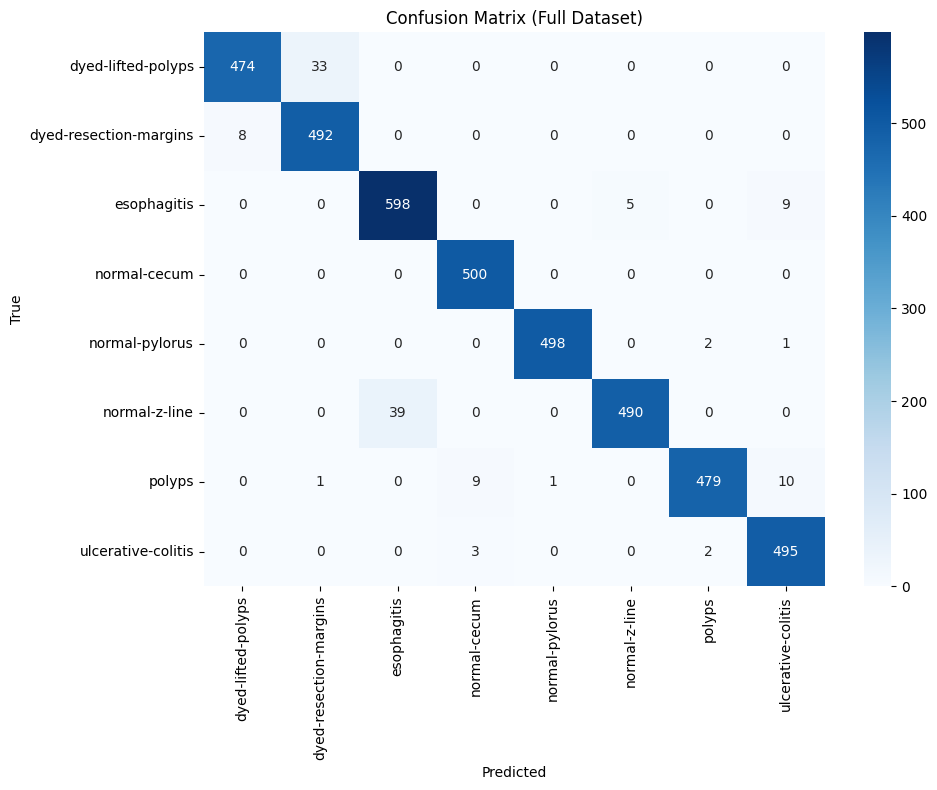

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create DataLoader for full dataset (no shuffling)
full_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

def classification_report_and_confusion_matrix(model, data_loader, class_names):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix (Full Dataset)")
    plt.tight_layout()
    plt.show()

# Run on full dataset
classification_report_and_confusion_matrix(vit, full_loader, full_dataset.classes)


#computational complexities


In [ ]:
pip install torchinfo


In [ ]:
 !pip install ptflops



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
from ptflops import get_model_complexity_info
import torch

#  ViT model is already defined and moved to device
# vit

# Using CPU  to get stable measurement;
device = torch.device("cpu")
model = vit.to(device)
model.eval()

with torch.no_grad():
    macs, params = get_model_complexity_info(
        model,
        (3, 224, 224),   # input size for ViT (same as ResNet50)
        as_strings=True,
        print_per_layer_stat=False,
        verbose=False
    )

print(f"Computational complexity (MACs): {macs}")
print(f"Number of parameters: {params}")


Computational complexity (MACs): 17.61 GMac
Number of parameters: 85.8 M


In [ ]:
from torchinfo import summary
import torch
from torchvision import models # Import models here as well

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vit = models.vit_b_16(pretrained=True)

# Accessing the in_features of the last layer in the Sequential module
in_features = vit.heads[-1].in_features
vit.heads = torch.nn.Linear(in_features, num_classes)

vit = vit.to(device)

summary(vit, input_size=(1, 3, 224, 224), device=str(device))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [1, 8]                    768
├─Conv2d: 1-1                                 [1, 768, 14, 14]          590,592
├─Encoder: 1-2                                [1, 197, 768]             151,296
│    └─Dropout: 2-1                           [1, 197, 768]             --
│    └─Sequential: 2-2                        [1, 197, 768]             --
│    │    └─EncoderBlock: 3-1                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-2                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-3                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-4                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-5                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-6                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-7             